# Семинар "Свёрточные нейронные сети и trasfer learning"
## Андрей Бояров, ведущий программист-исследователь команды машинного зрения

# Cвёрточные нейронные сети

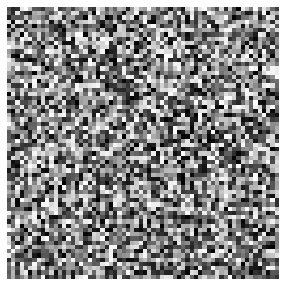

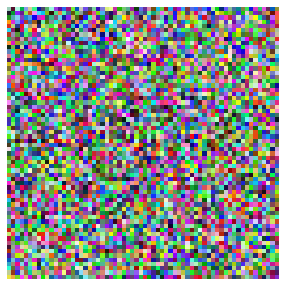

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL


def show_image(image, figsize=(16, 9), reverse=True):
    plt.figure(figsize=figsize)
    if reverse:
        plt.imshow(image[...,::-1])
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    
def show_grayscale_image(image, figsize=(16, 9)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
random_image = np.random.rand(64, 64)
show_grayscale_image(random_image, figsize=(10, 5))

random_image = np.random.rand(64, 64, 3)
show_image(random_image, figsize=(10, 5))

In [2]:
import torch
import torchvision

In [3]:
layer = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size=3)

In [4]:
layer.weight

Parameter containing:
tensor([[[[ 0.1067,  0.2696, -0.0902],
          [-0.0486, -0.3186, -0.0674],
          [ 0.0686, -0.2187,  0.1229]]]], requires_grad=True)

In [5]:
# вес доступен через .weight.data, нормализация веса
layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [6]:
layer.weight.data

tensor([[[[0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111],
          [0.1111, 0.1111, 0.1111]]]])

In [7]:
# Сделаем bayes= 0
layer.bias.data = torch.zeros_like(layer.bias.data)
layer.bias.data

tensor([0.])

In [8]:
layer.eval()

Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))

In [9]:
input_tensor = torch.arange(9).reshape(1, 1, 3, 3) # [batch_size, num_chunels, height, width]

In [10]:
input_tensor.shape

torch.Size([1, 1, 3, 3])

In [11]:
input_tensor

tensor([[[[0, 1, 2],
          [3, 4, 5],
          [6, 7, 8]]]])

In [12]:
output_tensor = layer(input_tensor.float())

In [13]:
output_tensor

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [14]:
(0.1111 * input_tensor).sum()

tensor(3.9996)

## Модификация весов свертки

In [24]:
path = 'data/bee.jpg'

In [27]:
# прочитайте изображение и переведите его в grayscale
img = cv2.imread(path, 0)

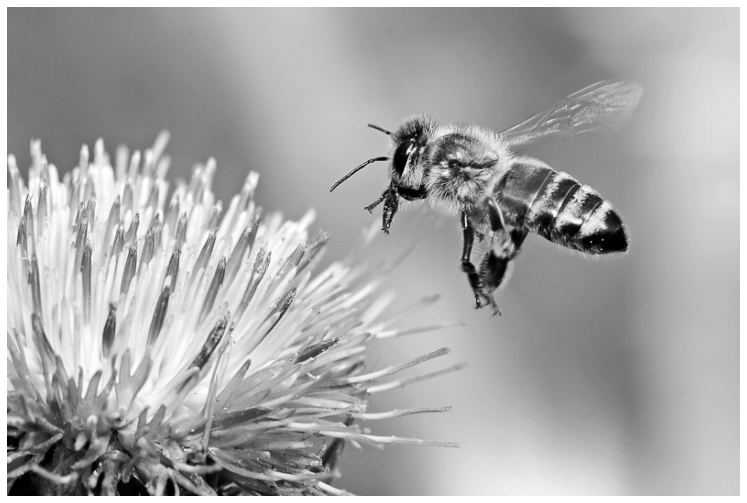

In [30]:
assert img.shape == (534, 800)
show_grayscale_image(img)

In [32]:
to_tensor = torchvision.transforms.ToTensor()
img_tensor = to_tensor(img)
img_tensor.shape

torch.Size([1, 534, 800])

In [33]:
# сделаейте так, чтобы assert в следующей строчке прошел
img_tensor = img_tensor.reshape((1, 1, 534, 800))

In [34]:
assert img_tensor.shape == torch.Size([1, 1, 534, 800])

## Создадим свертку, которая размоет изображение

In [35]:
kernel_size = 5
layer = torch.nn.Conv2d(1, 1, kernel_size=kernel_size)

In [36]:
# обновите веса так, чтобы получилась свертка, которая размывает изображение
layer.weight.data = torch.ones_like(layer.weight.data) 
layer.weight.data /= torch.sum(layer.weight.data)

In [37]:
layer.weight.data

tensor([[[[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]]]])

In [38]:
layer.eval()

Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))

In [39]:
output_tensor = layer(img_tensor)

In [40]:
output_tensor.shape

torch.Size([1, 1, 530, 796])

In [41]:
import torchvision.transforms as transforms

# функция, переводящее тензор в PIL-изображение
# Converts a torch.*Tensor of shape C x H x W or a numpy ndarray of shape
# H x W x C to a PIL Image while preserving the value range.
to_pil_image = transforms.ToPILImage()

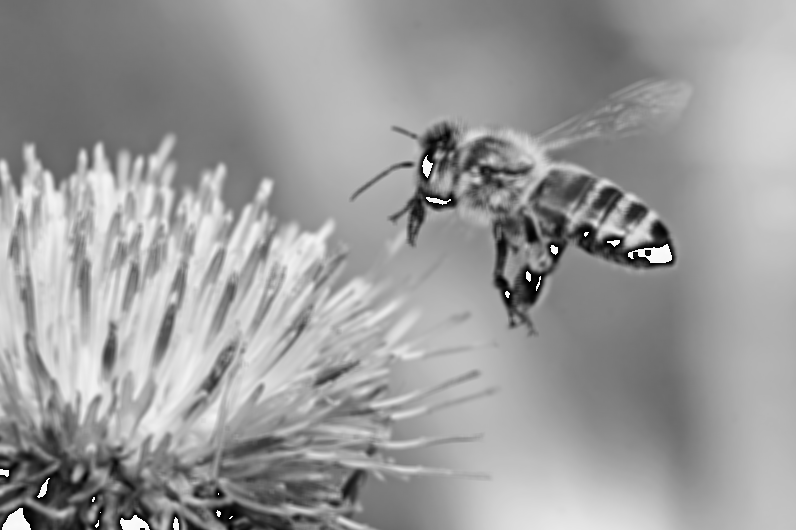

In [43]:
output_img = to_pil_image(output_tensor.squeeze(0))
output_img

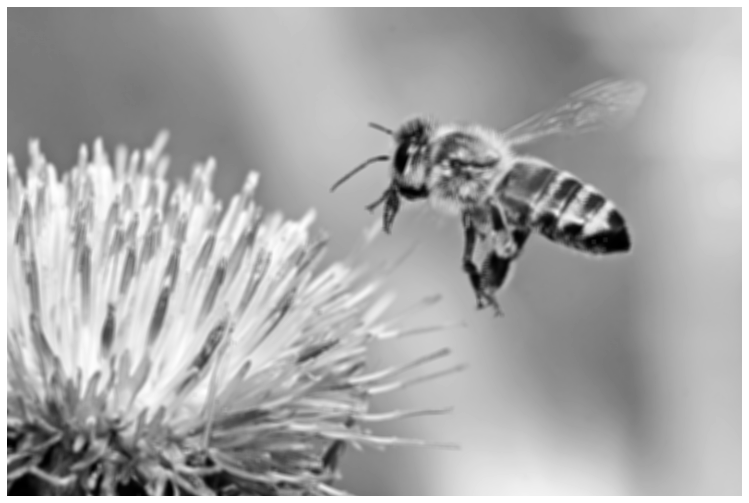

In [48]:
show_grayscale_image(output_tensor.squeeze().detach().numpy())

# Обучие моделей на изображениях

## Данные, преобразования

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [49]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [50]:
batch_size = 4

# dataset задаёт данные
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# dataloader подгружает их
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Отрисовка

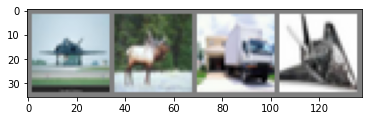

plane  deer  truck  plane


In [51]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# взять случайный батч изображений
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('  '.join('{}'.format(classes[labels[j]]) for j in range(4)))

## Рутина обучения модели

In [12]:
images.shape

torch.Size([4, 3, 32, 32])

In [55]:
def train_model(net, criterion, optimizer, trainloader, num_epochs=5):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            
            #дополните код
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print('Epoch {0}/{1}, iteration {2}, loss: {3:.3f}'.format(epoch + 1, num_epochs, i + 1, 
                                                                          running_loss / 2000))
                running_loss = 0.0
        print()

    print('Finished Training')
    
    return net

## Точность модели на тестовом сете

In [2]:
!jt -r

Reset css and font defaults in:
C:\Users\asus\.jupyter\custom &
C:\Users\asus\AppData\Roaming\jupyter\nbextensions


In [56]:
def all_accuracy(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            # дополните код
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(
        100 * correct / total))

In [57]:
def class_accuracy(net, testloader):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of {} : {} %'.format(
            classes[i], 100 * class_correct[i] / class_total[i]))

## Полносвязная сеть для классификации

In [58]:
import torch.nn as nn
import torch.nn.functional as F

# созлайте сеть, состоящую из 3-х полносвязных слоёв (input_size -> 128, 128 -> 32, 32 -> output_size) 
# и испрользовала в качестве активции ReLU

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        # tip: используйте функцию view для преобразования входа
        x = x.view(-1, 3 * 32 * 32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return x
    
net = FeedForwardNet()

In [59]:
import torch.optim as optim

# дополните код

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [60]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 1.953
Epoch 1/5, iteration 4000, loss: 1.756
Epoch 1/5, iteration 6000, loss: 1.686
Epoch 1/5, iteration 8000, loss: 1.605
Epoch 1/5, iteration 10000, loss: 1.598
Epoch 1/5, iteration 12000, loss: 1.570

Epoch 2/5, iteration 2000, loss: 1.494
Epoch 2/5, iteration 4000, loss: 1.498
Epoch 2/5, iteration 6000, loss: 1.496
Epoch 2/5, iteration 8000, loss: 1.478
Epoch 2/5, iteration 10000, loss: 1.464
Epoch 2/5, iteration 12000, loss: 1.468

Epoch 3/5, iteration 2000, loss: 1.391
Epoch 3/5, iteration 4000, loss: 1.392
Epoch 3/5, iteration 6000, loss: 1.394
Epoch 3/5, iteration 8000, loss: 1.412
Epoch 3/5, iteration 10000, loss: 1.401
Epoch 3/5, iteration 12000, loss: 1.399

Epoch 4/5, iteration 2000, loss: 1.324
Epoch 4/5, iteration 4000, loss: 1.334
Epoch 4/5, iteration 6000, loss: 1.345
Epoch 4/5, iteration 8000, loss: 1.345
Epoch 4/5, iteration 10000, loss: 1.342
Epoch 4/5, iteration 12000, loss: 1.333

Epoch 5/5, iteration 2000, loss: 1.267
Epoch 5/5, it

In [61]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 50.18 %


In [62]:
class_accuracy(net, testloader)

Accuracy of plane : 55.5 %
Accuracy of car : 63.7 %
Accuracy of bird : 45.0 %
Accuracy of cat : 28.8 %
Accuracy of deer : 27.6 %
Accuracy of dog : 33.3 %
Accuracy of frog : 67.3 %
Accuracy of horse : 62.5 %
Accuracy of ship : 69.7 %
Accuracy of truck : 48.4 %


## Свёрточная сеть для классификации

In [63]:
conv1 = nn.Conv2d(3, 6, 5)
conv1(torch.rand((32, 3, 32, 32))).shape

torch.Size([32, 6, 28, 28])

In [64]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) ## shape = (6, 14, 14)
        x = self.pool(F.relu(self.conv2(x))) ## shape = (16, 5, 5)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [65]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [66]:
net = train_model(net, criterion, optimizer, trainloader, num_epochs=5)

Epoch 1/5, iteration 2000, loss: 2.266
Epoch 1/5, iteration 4000, loss: 1.955
Epoch 1/5, iteration 6000, loss: 1.717
Epoch 1/5, iteration 8000, loss: 1.562
Epoch 1/5, iteration 10000, loss: 1.507
Epoch 1/5, iteration 12000, loss: 1.481

Epoch 2/5, iteration 2000, loss: 1.402
Epoch 2/5, iteration 4000, loss: 1.351
Epoch 2/5, iteration 6000, loss: 1.338
Epoch 2/5, iteration 8000, loss: 1.333
Epoch 2/5, iteration 10000, loss: 1.306
Epoch 2/5, iteration 12000, loss: 1.288

Epoch 3/5, iteration 2000, loss: 1.213
Epoch 3/5, iteration 4000, loss: 1.213
Epoch 3/5, iteration 6000, loss: 1.196
Epoch 3/5, iteration 8000, loss: 1.186
Epoch 3/5, iteration 10000, loss: 1.197
Epoch 3/5, iteration 12000, loss: 1.189

Epoch 4/5, iteration 2000, loss: 1.068
Epoch 4/5, iteration 4000, loss: 1.111
Epoch 4/5, iteration 6000, loss: 1.118
Epoch 4/5, iteration 8000, loss: 1.090
Epoch 4/5, iteration 10000, loss: 1.084
Epoch 4/5, iteration 12000, loss: 1.081

Epoch 5/5, iteration 2000, loss: 0.987
Epoch 5/5, it

In [67]:
# сохраним сеть
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

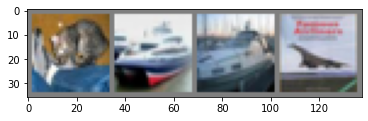

GroundTruth:  cat ship ship plane


In [68]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('{}'.format(classes[labels[j]]) for j in range(batch_size)))

In [70]:
# загрузим сеть
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [71]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('{}'.format(classes[predicted[j]]) for j in range(4)))

Predicted:  ship ship ship plane


In [72]:
all_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 59.34 %


In [74]:
class_accuracy(net, testloader)

Accuracy of plane : 65.6 %
Accuracy of car : 80.2 %
Accuracy of bird : 44.6 %
Accuracy of cat : 53.8 %
Accuracy of deer : 59.1 %
Accuracy of dog : 47.6 %
Accuracy of frog : 69.1 %
Accuracy of horse : 65.0 %
Accuracy of ship : 69.1 %
Accuracy of truck : 65.2 %


### Cuda

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

# Transfer learning 

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

## Данные, предобработка

In [78]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'

# image_datasets = dict{key, dataset}, dataset=ImageFolder(path, transforms)
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

# dataloaders = dict{key: DataLoader(dataset, batch_size)}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(f"Size of datsets: {dataset_sizes}")
class_names = image_datasets['train'].classes
print(f"{class_names=}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

Size of datsets: {'train': 244, 'val': 153}
class_names=['ants', 'bees']
device=device(type='cpu')


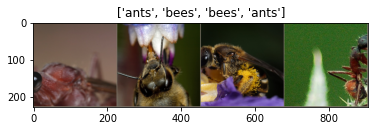

In [79]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) # in numpy -> (height, width, channels)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Рутина обучения

In [80]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

## Визуализация работы модели

In [81]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Предобученный на ImageNet ResNet-18

In [82]:
images.shape

torch.Size([4, 3, 32, 32])

In [ ]:
model_ft(images)

In [90]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
print(f"{num_ftrs=}")
model_ft.fc = nn.Linear(num_ftrs, 2)

num_ftrs=512


In [91]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [89]:
# model_ft(images)

tensor([[-0.8756,  0.6124],
        [ 0.3534, -0.5528],
        [ 1.5217, -0.4313],
        [ 0.8658, -0.6074]], grad_fn=<AddmmBackward0>)

## Дообучаем все слои

In [92]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.7963 Acc: 0.6270
val Loss: 0.2915 Acc: 0.9020

Epoch 1/4
----------
train Loss: 0.7687 Acc: 0.7541
val Loss: 0.3758 Acc: 0.8497

Epoch 2/4
----------
train Loss: 0.4389 Acc: 0.8238
val Loss: 0.2169 Acc: 0.9150

Epoch 3/4
----------
train Loss: 0.3251 Acc: 0.8689
val Loss: 0.1560 Acc: 0.9281

Epoch 4/4
----------
train Loss: 0.3622 Acc: 0.8607
val Loss: 0.1472 Acc: 0.9346

Training complete in 5m 7s
Best val Acc: 0.934641


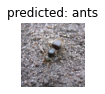

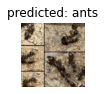

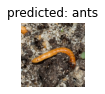

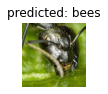

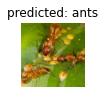

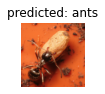

In [93]:
visualize_model(model_ft)

## Теперь дообучаем только последний слой

In [94]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    # градиенты теперь не будут здесь протекать
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
# по умолчанию requires_grad = True
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.1)

In [95]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6515 Acc: 0.6475
val Loss: 0.2047 Acc: 0.9346

Epoch 1/4
----------
train Loss: 0.4753 Acc: 0.7787
val Loss: 0.6768 Acc: 0.7255

Epoch 2/4
----------
train Loss: 0.4501 Acc: 0.8033
val Loss: 0.1954 Acc: 0.9542

Epoch 3/4
----------
train Loss: 0.3446 Acc: 0.8443
val Loss: 0.1867 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.3629 Acc: 0.8402
val Loss: 0.1969 Acc: 0.9477

Training complete in 2m 23s
Best val Acc: 0.954248


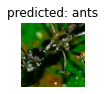

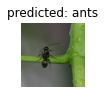

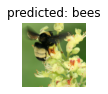

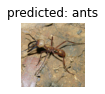

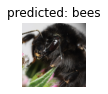

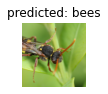

In [96]:
visualize_model(model_conv)

# Оцека эстетической красоты фотографии

Необходимо для сортировки пользовательских фотографий, выбора лучшего кадра для превью и т.д.

A Large-Scale Database for Aesthetic Visual Analysis (AVA): 255 000 изображений, для каждого фото около 200 людей выставили оценку от 1 (плохо) до 10 (хорошо)

![](./data/photos/ava_examples.png)

![aaa](./data/photos/ava_mean_std.png)

1. ResNet-18, предобученная на ImageNet для извлечения признаков.
2. Добавляем несколько полносвязных слоёв, которые обучаются на AVA.
3. Используем Earth Mover’s Distance

![](./data/photos/emd.png)